# Keras

### find the dimensions of an image

In [1]:
from keras.models import Sequential
from os import listdir
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread
from scipy.misc import imshow
import tensorflow as tf
import os
print(os.listdir("."))
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


['kaggleJupyter', 'searches', '.DS_Store', 'test', 'dataGetter', 'pictures', 'launchData', 'models', 'README.md', '.gitignore', 'allunia.ipynb', 'train', 'readmePics', 'train.csv', '.ipynb_checkpoints', '.git', 'vitolyByrachonok.ipynb', 'foolishBaseline.ipynb', 'sample_submission.csv', '.idea', 'src']


# Initialize train labels, label names ------------------

In [2]:
train_labels = pd.read_csv("train.csv")
# train_labels.head()

labels = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in labels.items())

def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = labels[int(num)]
        row.loc[name] = 1
    return row

for key in labels.keys():
    train_labels[labels[key]] = 0

train_labels = train_labels.apply(fill_targets, axis=1)
# train_labels.head()

# Read pictures into numpy array --------------------

In [3]:
base = "train/"
blue = "_blue.png"
red = "_red.png"
yellow = "_yellow.png"
green = "_green.png"

### train data

In [ ]:
trials = len(train_labels)
y = np.ones(trials)
x = np.ones((1,512,512,4))
for i in range(trials):
    b = imread(base + train_labels.at[i, 'Id'] + red).reshape((512,512,1))
    r = imread(base + train_labels.at[i, 'Id'] + red).reshape((512,512,1))
    ye = imread(base + train_labels.at[i, 'Id'] + yellow).reshape((512,512,1))
    g = imread(base + train_labels.at[i, 'Id'] + green).reshape((512,512,1))
    im = np.append(b, r, axis=2)
    im = np.append(im, ye, axis=2)
    im = np.append(im, g, axis=2)
    x = np.append(x, [im], axis=0)
    y[i] = train_labels.at[i, labels.get(0)]
    
x = x[1:,:,:,:]
y = y.reshape(trials,1)

print(x.shape); print(y.shape);

### test data

In [ ]:
trials_test = 10
y_test = np.ones(trials_test)
x_test = np.ones((1,512,512,4))
for i in range(trials_test):
    b = imread(base + train_labels.at[i+trials, 'Id'] + red).reshape((512,512,1))
    r = imread(base + train_labels.at[i+trials, 'Id'] + red).reshape((512,512,1))
    ye = imread(base + train_labels.at[i+trials, 'Id'] + yellow).reshape((512,512,1))
    g = imread(base + train_labels.at[i+trials, 'Id'] + green).reshape((512,512,1))
    im = np.append(b, r, axis=2)
    im = np.append(im, ye, axis=2)
    im = np.append(im, g, axis=2)
    x_test = np.append(x_test, [im], axis=0)
    y_test[i] = train_labels.at[i+trials, labels.get(0)]

x_test = x_test[1:,:,:,:]
y_test= y_test.reshape((trials_test,1));

print(x_test.shape); print(y_test.shape);

### Reshape and build iterators

In [ ]:
# set the data
categories = 2
x_train = x
y_train = keras.utils.to_categorical(y, num_classes=categories)
x_val = x_test
y_val = keras.utils.to_categorical(y_test, num_classes=categories)

from keras.preprocessing import image
gen = image.ImageDataGenerator()

train_iter = gen.flow(x_train, y_train, batch_size=2)
val_iter = gen.flow(x_val, y_val, batch_size=2)

# Read using keras.utils.Sequence --------------------------

In [4]:
base = "train/"
blue = "_blue.png"
red = "_red.png"
yellow = "_yellow.png"
green = "_green.png"

from skimage.io import imread
from skimage.transform import resize
import numpy as np
from keras.utils import Sequence

# Here, `x_set` is list of path to the images
# and `y_set` are the associated classes.

class CIFAR10Sequence(Sequence):

    def __init__(self, train_labels, batch_size):
        self.train_labels = train_labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.train_labels) / float(self.batch_size)))

    def __getitem__(self, idx):
        trials = len(self.train_labels)
        y = np.ones(self.batch_size)
        x = np.ones((1,512,512,4))
        for i in range(self.batch_size):
            sample = i + idx*self.batch_size 
            b = imread(base + train_labels.at[sample, 'Id'] + red).reshape((512,512,1))
            r = imread(base + train_labels.at[sample, 'Id'] + red).reshape((512,512,1))
            ye = imread(base + train_labels.at[sample, 'Id'] + yellow).reshape((512,512,1))
            g = imread(base + train_labels.at[sample, 'Id'] + green).reshape((512,512,1))
            im = np.append(b, r, axis=2)
            im = np.append(im, ye, axis=2)
            im = np.append(im, g, axis=2)
            x = np.append(x, [im], axis=0)
            y[i] = train_labels.at[sample, labels.get(0)]

        x = x[1:,:,:,:]
        y = y.reshape(self.batch_size,1)
        y = keras.utils.to_categorical(y, num_classes=2)
        
        return x, y

# Build Model ------------------------

In [10]:
ax0range=10; ax1range=512; ax2range=512; ax3range=4;
categories = 2;

model = Sequential()
# input: 100x100 images with 3 channels -> (100, 100, 3) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(ax1range, ax2range, ax3range)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(categories, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd)

# Memory usage ---------------------------------------------------


I can build a keras.utils.Sequence, and call its functions, and they appear to be working. But I can not call the models fit method on these sequences. There is a good chance I have not defined all the callbacks i need to, or I defined one incorrectly. But this is mystifying to me. Ok, it turned out that you have to have your output reshaped (N, 2), and you had is shaped as (N,1). It wanted a column for each category, and a mark in the column to indicate yes or no, but you had one column with the category in it. I ended up googling my exact problem. 

That is resolved, but my computer is still overwhelmed and shuts down. Questions: 1) What if i do this with less data? and 2)a fresh container 3)make more resources available to docker. 4) smaller batch size. 5)Do I need to go research how the sequence object works? Or read articles on how to run keras models with less memory requirements? 

### Fit using numpy arrays

In [ ]:
model.fit()

### Fit using iterators

In [22]:
history = model.fit_generator(generator = train_iter, steps_per_epoch=train_iter.n, epochs=10,
                              validation_data = val_iter, validation_steps=val_iter.n)

Epoch 1/10
10/10 [==============================] - 44s 4s/step - loss: 7.2539 - val_loss: 4.8354
Epoch 2/10
10/10 [==============================] - 38s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 3/10
10/10 [==============================] - 39s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 4/10
10/10 [==============================] - 38s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 5/10
10/10 [==============================] - 38s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 6/10
10/10 [==============================] - 39s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 7/10
10/10 [==============================] - 39s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 8/10
10/10 [==============================] - 38s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 9/10
10/10 [==============================] - 38s 4s/step - loss: 8.0590 - val_loss: 4.8354
Epoch 10/10
10/10 [==============================] - 38s 4s/step - loss: 8.0590 - val_loss: 4.8354


In [40]:
score = model.evaluate(x_val, y_val, batch_size=2)
score

10/10 [==============================] - 3s 323ms/step


4.835428667068487

### Fit using keras.utils.Sequence

In [9]:
len(train_labels[0:500])

500

In [61]:
model.fit_generator(generator = CIFAR10Sequence(train_labels=train_labels[0:500], batch_size=50), 
                    validation_data = CIFAR10Sequence(train_labels=train_labels[500:600], batch_size=10))


Epoch 1/1


ValueError: Error when checking target: expected dense_2 to have shape (2,) but got array with shape (1,)

In [11]:
model.fit_generator(generator = CIFAR10Sequence(train_labels=train_labels[0:200], batch_size=10), 
                    steps_per_epoch = 200,
                    epochs = 10,
                    validation_data = CIFAR10Sequence(train_labels=train_labels[200:220], batch_size=5),
                    validation_steps = 20)

Epoch 1/10
153/200 [=====================>........] - ETA: 12:53 - loss: 9.8826

KeyboardInterrupt: 

In [72]:
sequence= CIFAR10Sequence(train_labels = train_labels[0:500], batch_size=50)

In [73]:
validation_data = CIFAR10Sequence(train_labels=train_labels[500:600], batch_size=10)

In [74]:
x,y = sequence.__getitem__(1)


In [75]:
y.shape

(50, 2)

not 50 2 1, with the number of dimensions changed. The difference here is that
you have two columns per output instead of 1. 

# Make predictions, get an F1 score ------------------------------------

In [41]:
def confusionMatrix(y_pred, y_test):
    """the input matrices must have dimension N X 2"""
    assert len(y_pred) == len(y_test)
    y_pred = y_pred.astype(int)[:,1]
    y_test = y_test.astype(int)[:,1]

    c = np.array([[0,0],[0,0]]) # first index gives you actual class. Second index tells you predicted class.
    for i in range(len(y_pred)):
        c[y_test[i], y_pred[i]] += 1
    return c
def f1(c):
    recall = c[0][0]/(c[0][0]+c[0][1])
    precision = c[0][0]/(c[0][0]+c[1][0])
    f1 = 2*recall*precision/(recall+precision)
    return f1

In [42]:
y_pred = model.predict(x_val, batch_size=2)
c = confusionMatrix(y_pred, y_val)
score = f1(c)
print(score)

0.8235294117647058


In [44]:
y_pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [46]:
y_pred_untrained = model.predict(x_test, batch_size=2)

# Save the model

In [43]:
model.save_weights("poorlyTrained")

# Old Work, shuttered

## Build model

In [8]:
b = imread(base + train_labels.at[0, 'Id'] + blue)

In [9]:
b.shape

(512, 512)

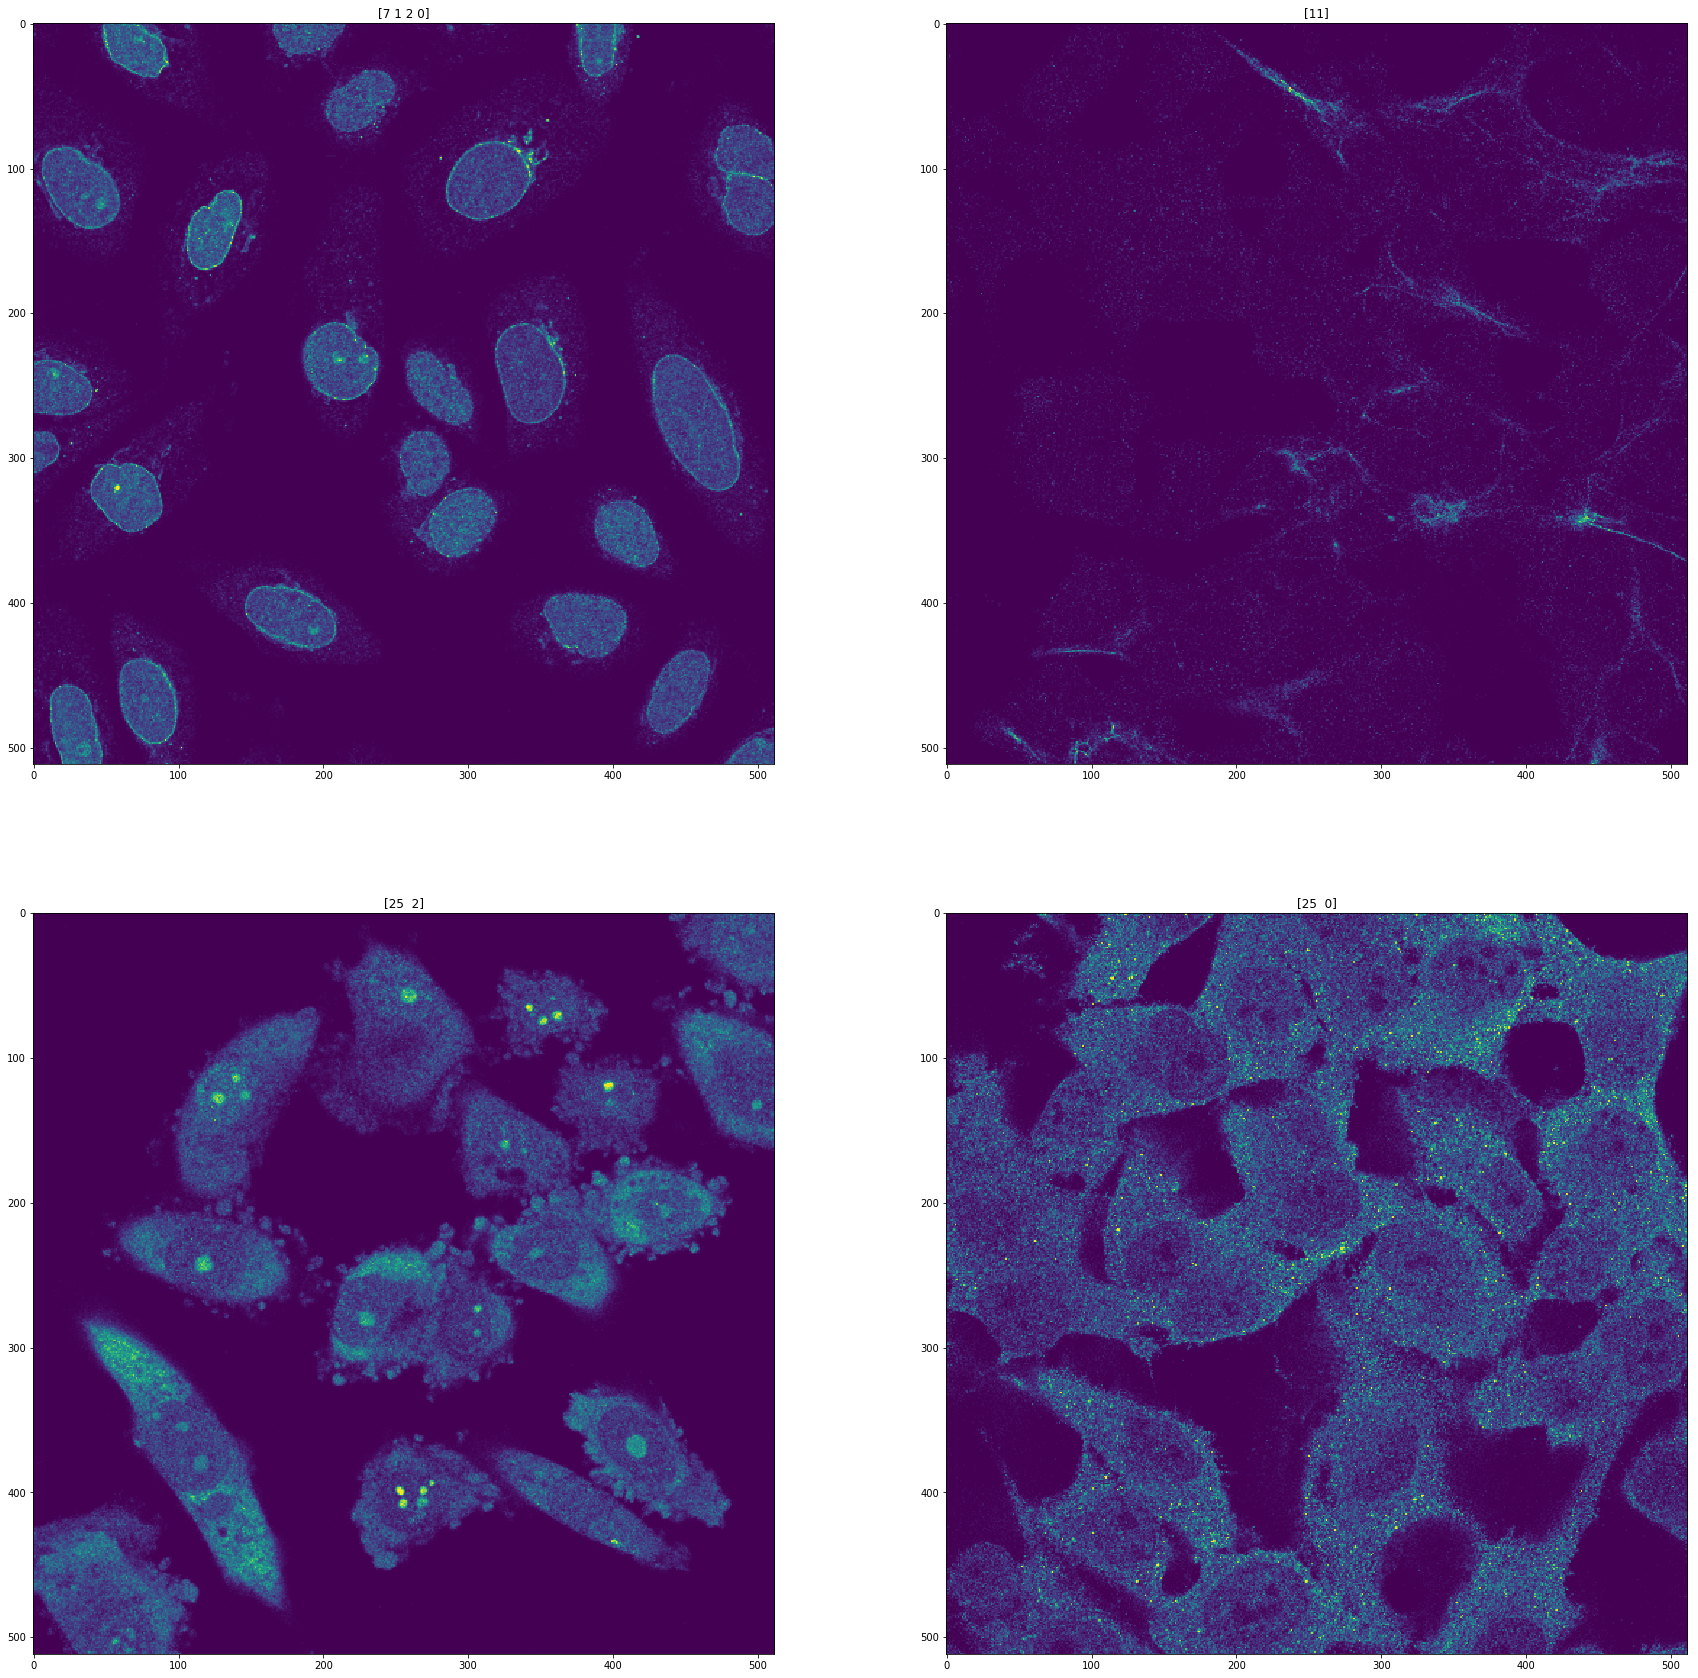

In [57]:
first = 4; sec = 5; third = 6; fourth = 7;

o = imread(base + train_labels.at[first, 'Id'] + green)
t = imread(base + train_labels.at[sec, 'Id'] + green)
th = imread(base + train_labels.at[third, 'Id'] + green)
f = imread(base + train_labels.at[fourth, 'Id'] + green)

fit = plt.figure(figsize=(30,30))
goup = 5
for i in range(4):
    plt.subplot(2, 2, i+1)
    answer = train_labels.at[i+goup*4, 'Target']
    f = imread(base + train_labels.at[i+goup*4, 'Id'] + green) 
    plt.title(answer)
    plt.imshow(f)

# plt.subplot(2, 2, 2)
# answer = train_labels.at[sec, 'Target']
# plt.title(answer)
# plt.imshow(t)
# 
# plt.subplot(2, 2, 3)
# answer = train_labels.at[third, 'Target']
# plt.title(answer)
# plt.imshow(th)
# 
# plt.subplot(2, 2, 4)
# answer = train_labels.at[fourth, 'Target']
# plt.title(answer)
# plt.imshow(f)



In [123]:
din = int(x.shape[1])
first_layer = int(din/4)

In [124]:
din

5000

In [125]:
first_layer

1250

In [126]:
model = Sequential()
model.add(Dense(units=first_layer, activation='relu', input_dim=din))
model.add(Dense(units=1, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])


In [127]:
model.fit(x, y, epochs=5, batch_size=40)

Epoch 1/5
2000/2000 [==============================] - 3s 1ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 2/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 3/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 4/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - acc: 0.0000e+00
Epoch 5/5
2000/2000 [==============================] - 2s 1ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


In [128]:
b = imread(base + train_labels.at[0, 'Id'] + blue).reshape((512*512))[0:picSize].reshape((1,picSize))
model.predict(b)

array([[1.]], dtype=float32)

## Why does my model fail to train? The input is read successfully. It just stalls out. 1) Docker doesn't have enough resources 2) No Keras model with this big of input will ever work. 3) I have made a mistake constructing the model. The output has to be defined a different way or something. THE PROBLEM WAS: 

so you go make basic models until you can look at your model and say, that is a reasonably shaped network, and the commands I am using to build the network are the appropriate commands. This is a baseline image classification network.

The problem is that the images are motherfucking huge. Is the protien in just one spot, or is it spread out? Can I look all throughout the image and see it everywhere? By this, I mean can I just break the image into smaller components?

If I run my little baseline, but I just chop off and make the input smaller, will it work?